<h1>Time to Peak Biomarkers in Lung MRI Imaging </h1>
<h3>Dataset: 12 phase registered image </h3>

In [1]:
%matplotlib notebook
import numpy as np
import nibabel as nib
import sigpy.plot as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from numpy.polynomial.polynomial import Polynomial

<h1>Loading the data...<h1>

In [2]:
#Load registered image
registered = nib.load("result_nomask.nii")
registered = np.array(registered.dataobj)

<IPython.core.display.Javascript object>


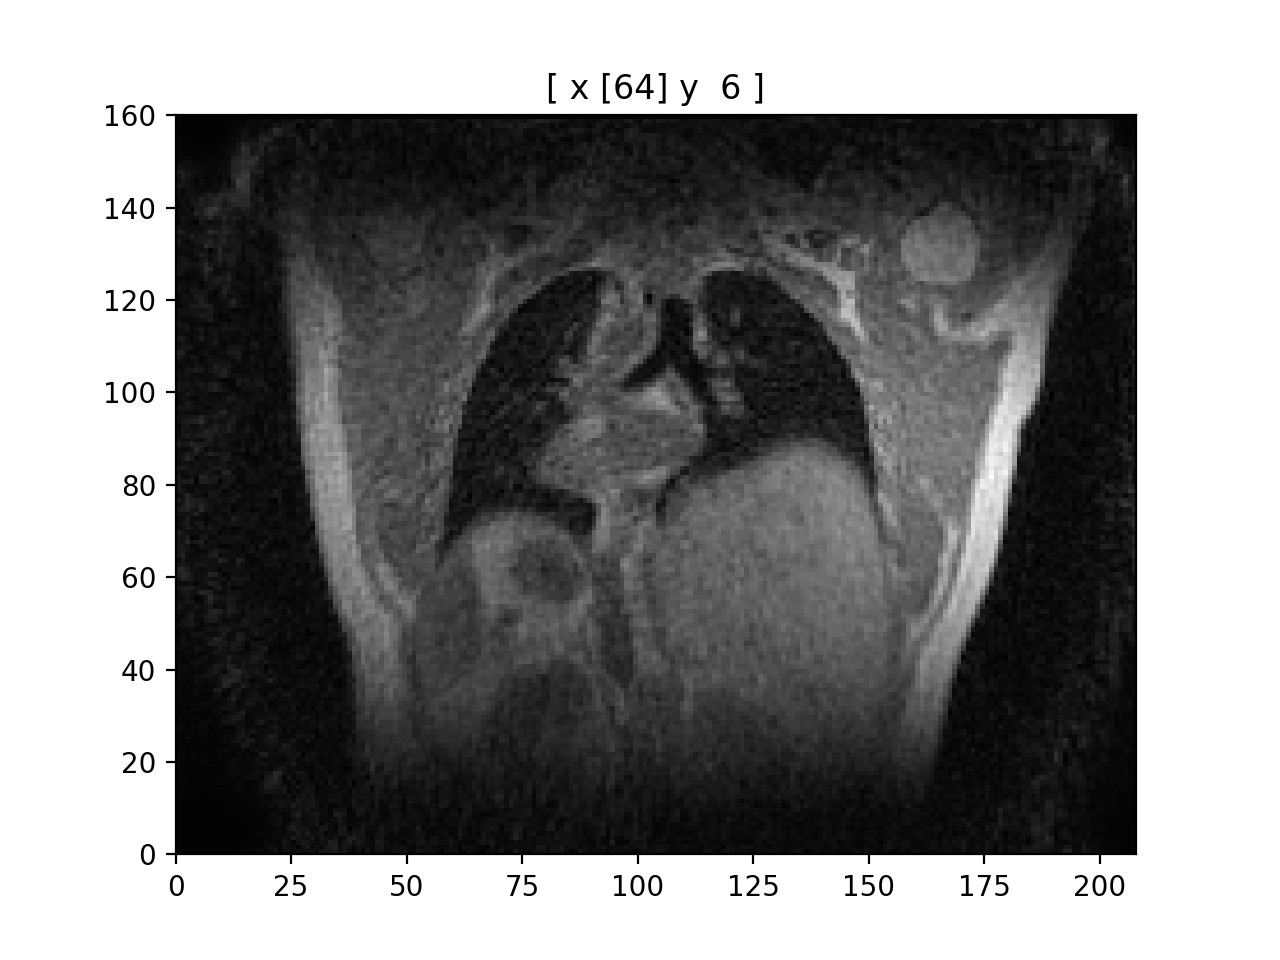

In [3]:
#Plot registered image
pl.ImagePlot(registered, x=0)

In [4]:
#Load lung mask 
mask = nib.load("lung_mask_close.nii")
mask = np.array(mask.dataobj)

<IPython.core.display.Javascript object>


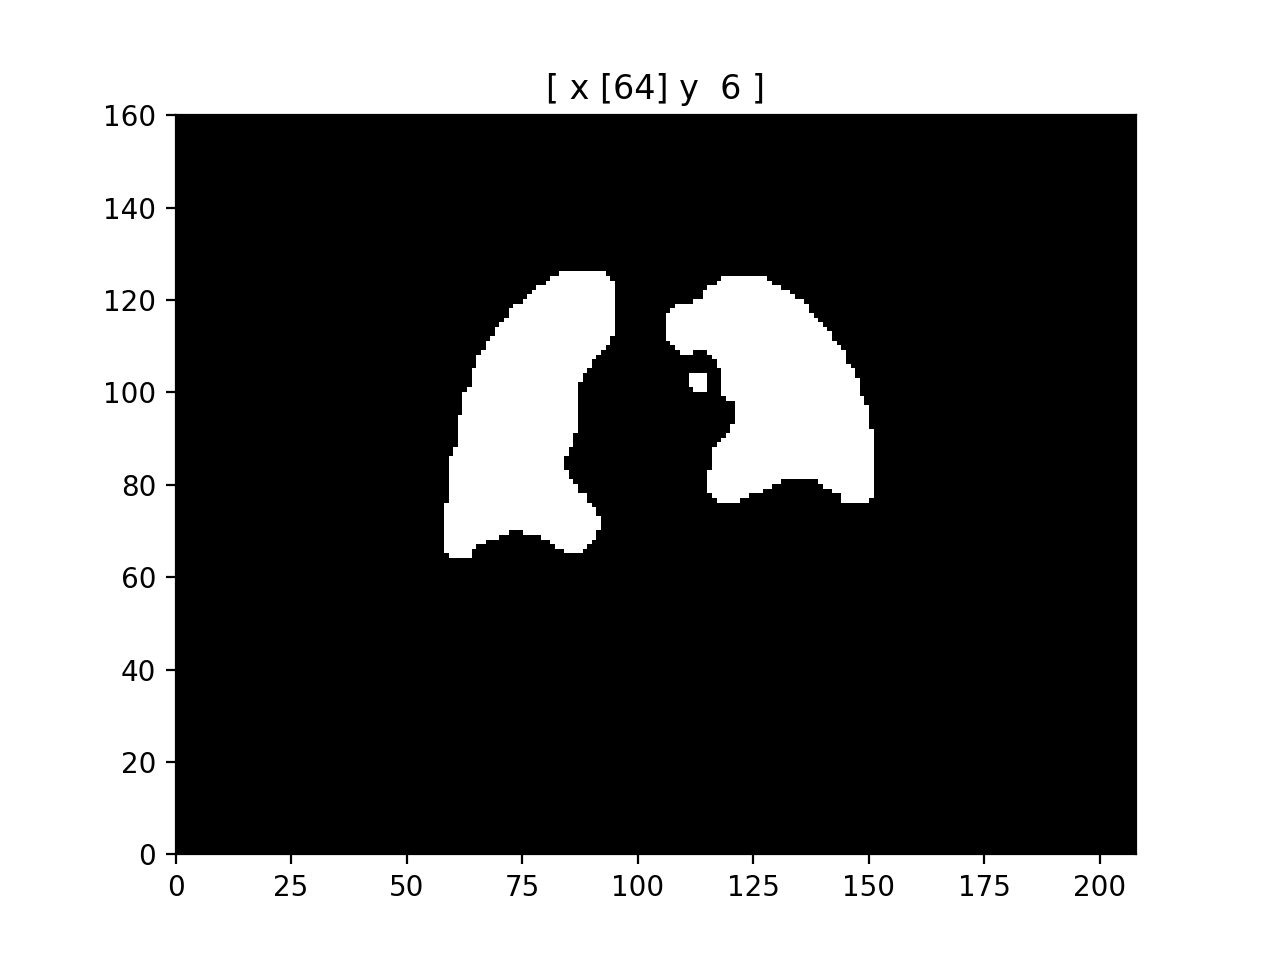

In [5]:
#Plot lung mask
pl.ImagePlot(mask, x=0)

<IPython.core.display.Javascript object>


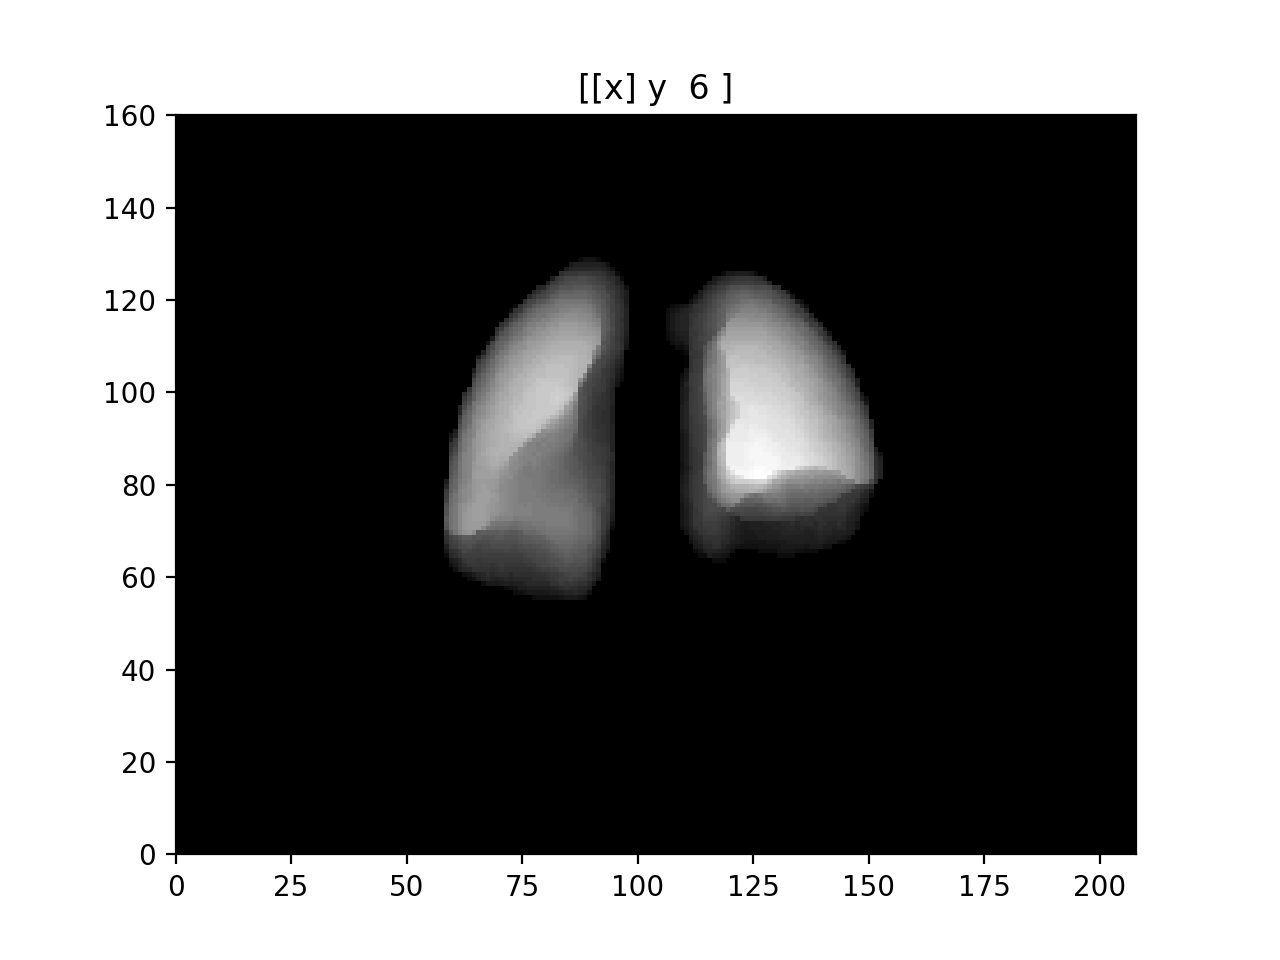

In [6]:
#Plot lung mask image in '3D'
pl.ImagePlot(np.mean(mask, axis=1), mode='r', x=0)

<h1>Lung Mask Voxel Sample<h1>

In [7]:
#Multiply lung mask with registered image 
registered_mask = np.empty((208, 128, 160, 12))
for i in range(12):
    registered_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask[:,:,:,i])

In [8]:
#Rearange the lung respiration phases to: inspiration, exhalation, then inspiration
registered_mask = np.append(registered_mask[:,:,:,6:], (registered_mask[:,:,:,:6]), axis=3)

<IPython.core.display.Javascript object>


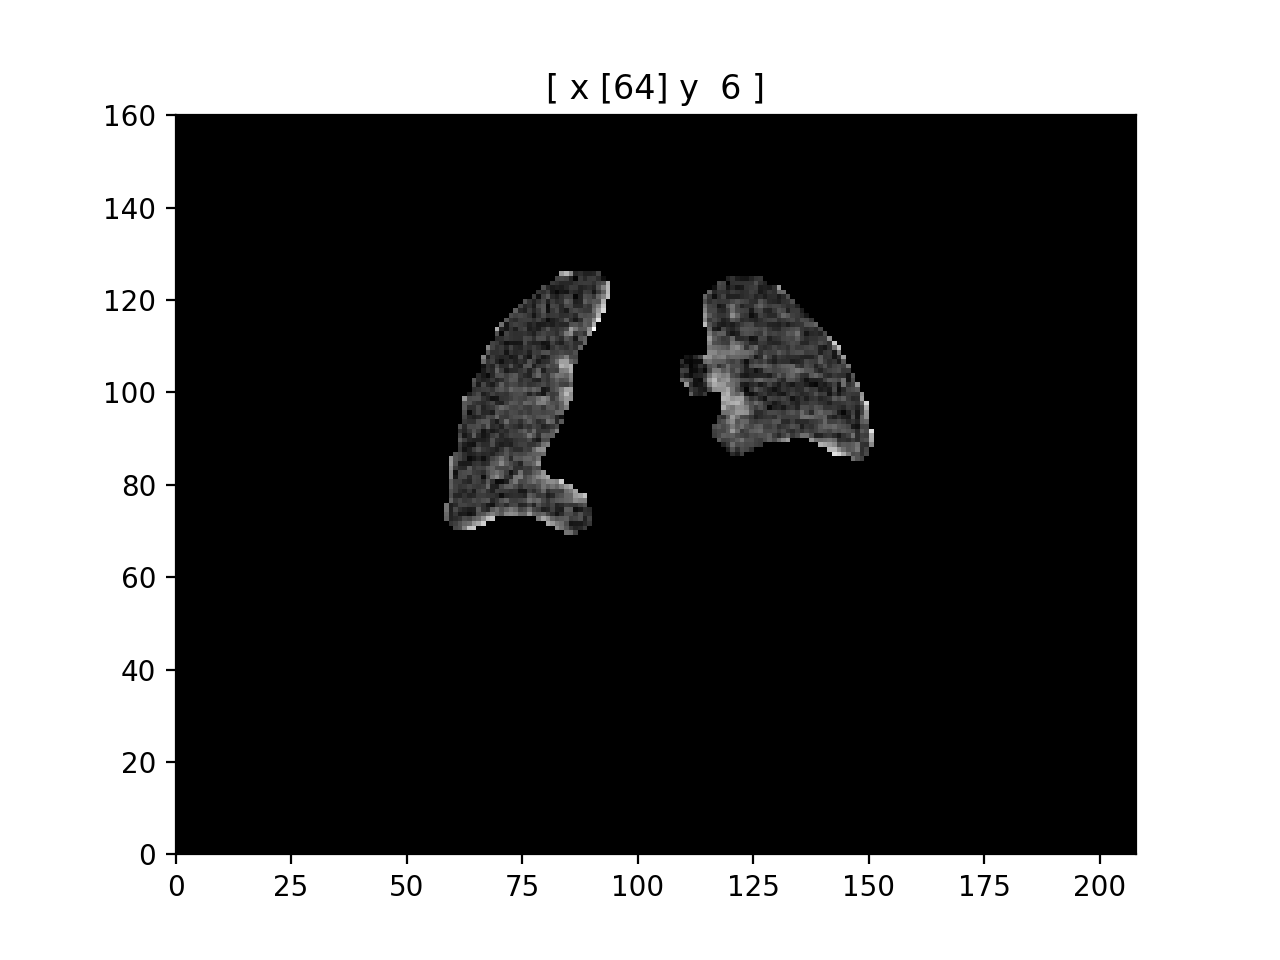

In [9]:
#Plot registered lung mask image
pl.ImagePlot(registered_mask, x=0)

In [10]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

In [11]:
#Calculate 4, 2 voxel sample
voxel_sample_4 = voxel_sample(registered_mask, 4)
voxel_sample_2 = voxel_sample(registered_mask, 2)

<IPython.core.display.Javascript object>


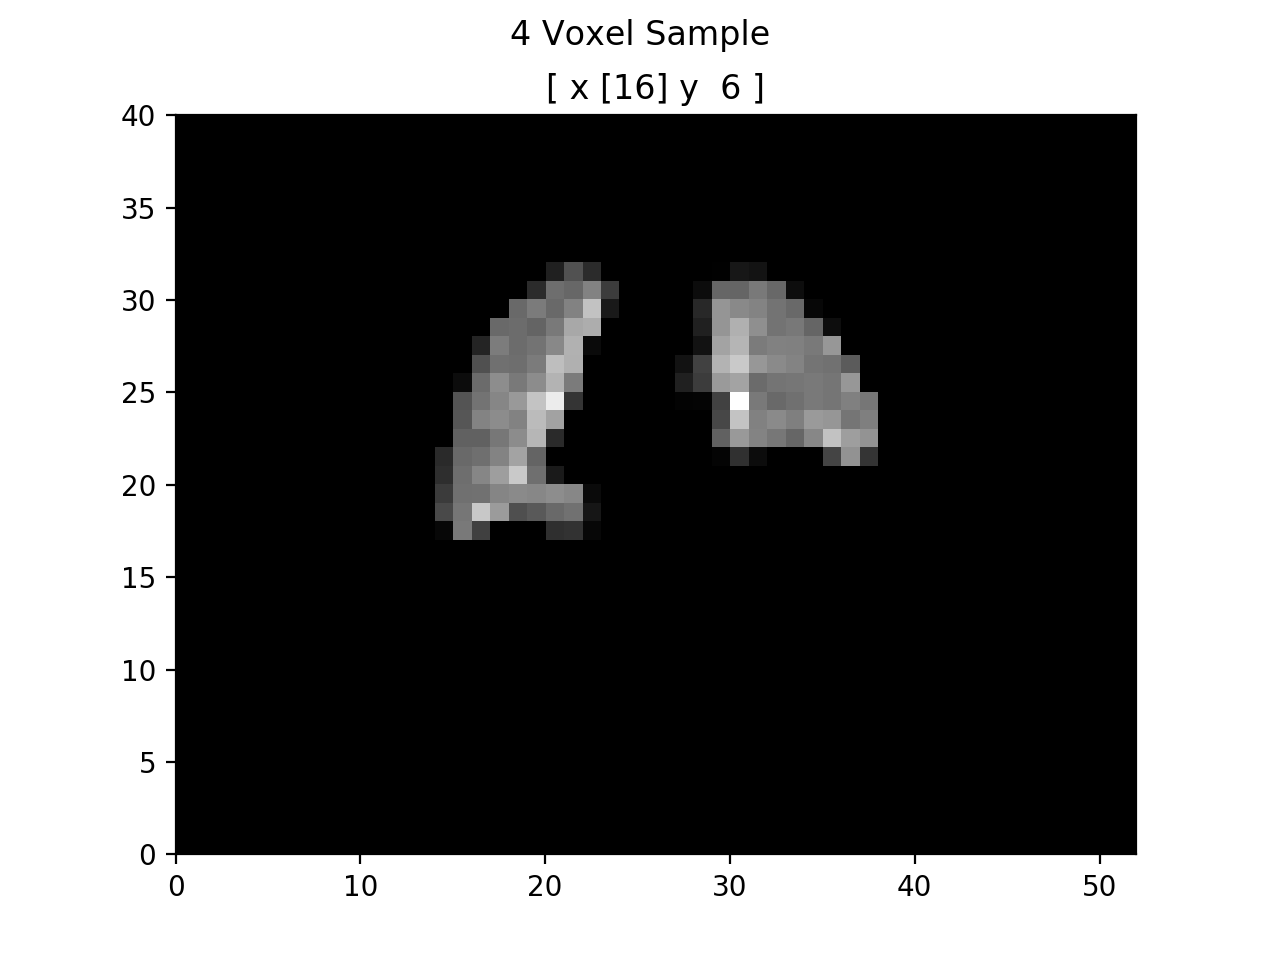

In [12]:
#Plot 4x4x4 voxel sample image
pl.ImagePlot(voxel_sample_4, x=0, title='4 Voxel Sample')

<IPython.core.display.Javascript object>


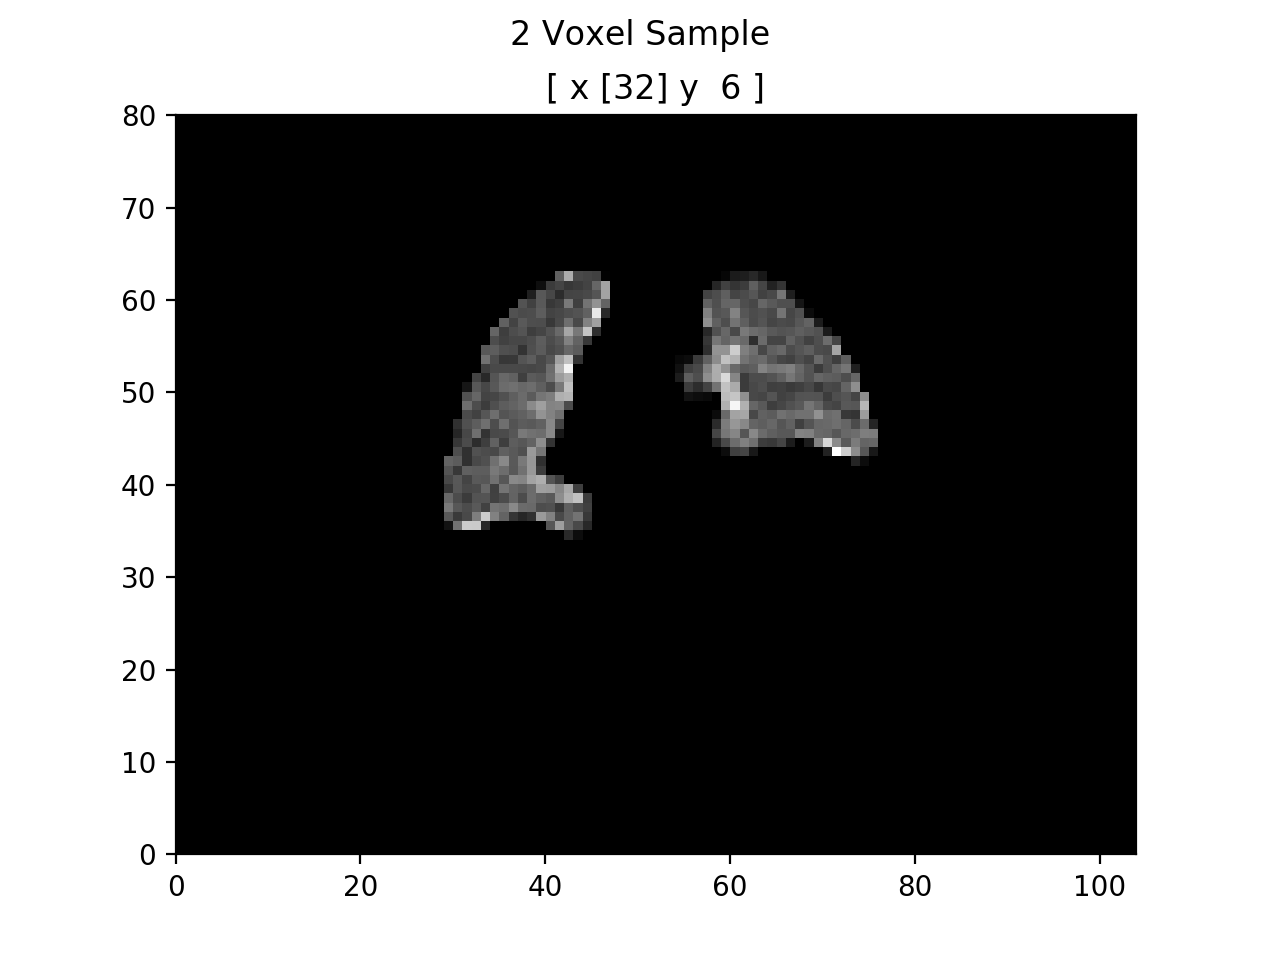

In [13]:
#Plot 2x2x2 voxel sample image
pl.ImagePlot(voxel_sample_2, x=0, title='2 Voxel Sample')

<h1> Time to Peak with Lagrange Curve Fitting <h1>

In [15]:
#Computes lagrange polynomial for values in [0,11]
#y_values: array of intensity values
def lagrange_curve_fitting(y_values, samples):
    lagrange_x = np.linspace(0, 11, 12)
    lagrange_y = y_values
    x = np.linspace(0, 11, num=samples)
    poly = lagrange(lagrange_x, lagrange_y)
    lagrange_coef = Polynomial(poly).coef
    return x, poly(x)

In [16]:
#Plot time to peak intensity with lagrange curve fit 
def plot_TTP_langrange(intensity_values):
    lagrange_x, lagrange_y = lagrange_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(12), intensity_values, label='Intensity')
    plt.plot(lagrange_x, lagrange_y, label='Lagrange Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [17]:
#Calculates time to peak with lagrange curve fitting
#Investigate if np.apply_over_axis or np.apply_along_axis can speed up algorithm 
def calculate_time_to_peak(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = lagrange_curve_fitting(slice_1D, 20)
                    max_y = max(fitted_y)
                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [18]:
#Validate time to peak algorithm by plotting
def validate_ttp_sample(x, y, sample):
    sample_array = sample[x,16,y,:]
    plot_TTP_langrange(sample_array)
    
    fitted_x, fitted_y = lagrange_curve_fitting(sample_array, 20)
    ttp_x = fitted_x[np.argmax(fitted_y)]

    print("Time to peak value of algorithm: ", ttp_x)
    print("Time to peak value of image: ", time_to_peak_4[x,16,y])
    print("isSame: ", time_to_peak_4[x,16,y] == ttp_x)

In [19]:
#Calculate time to peak with lagrange curve fitting for a 4 voxel sample
time_to_peak_4 = calculate_time_to_peak(voxel_sample_4)

<IPython.core.display.Javascript object>


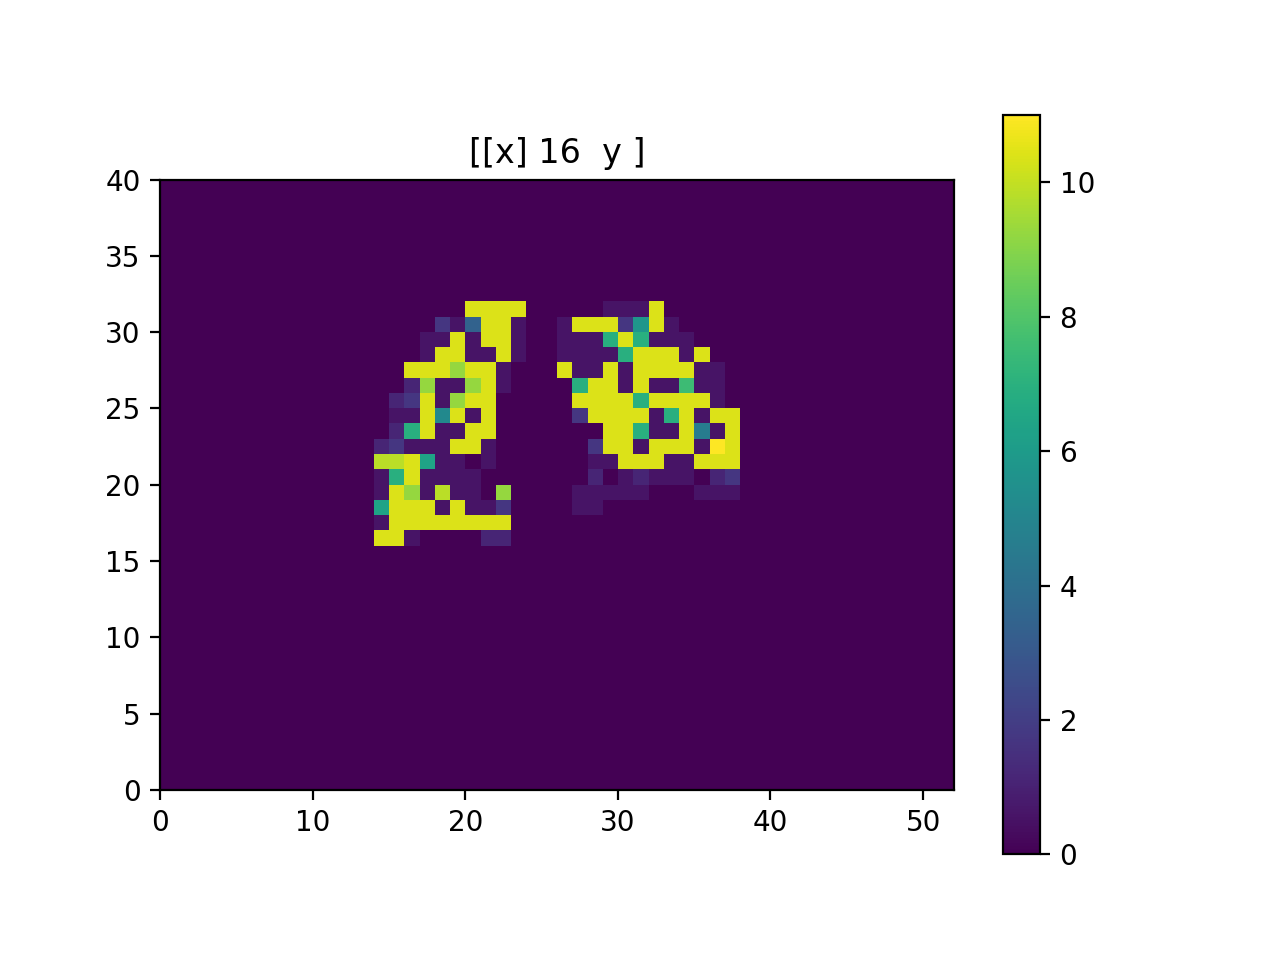

In [20]:
#Plot time to peak of a 4 voxel sample
pl.ImagePlot(time_to_peak_4, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


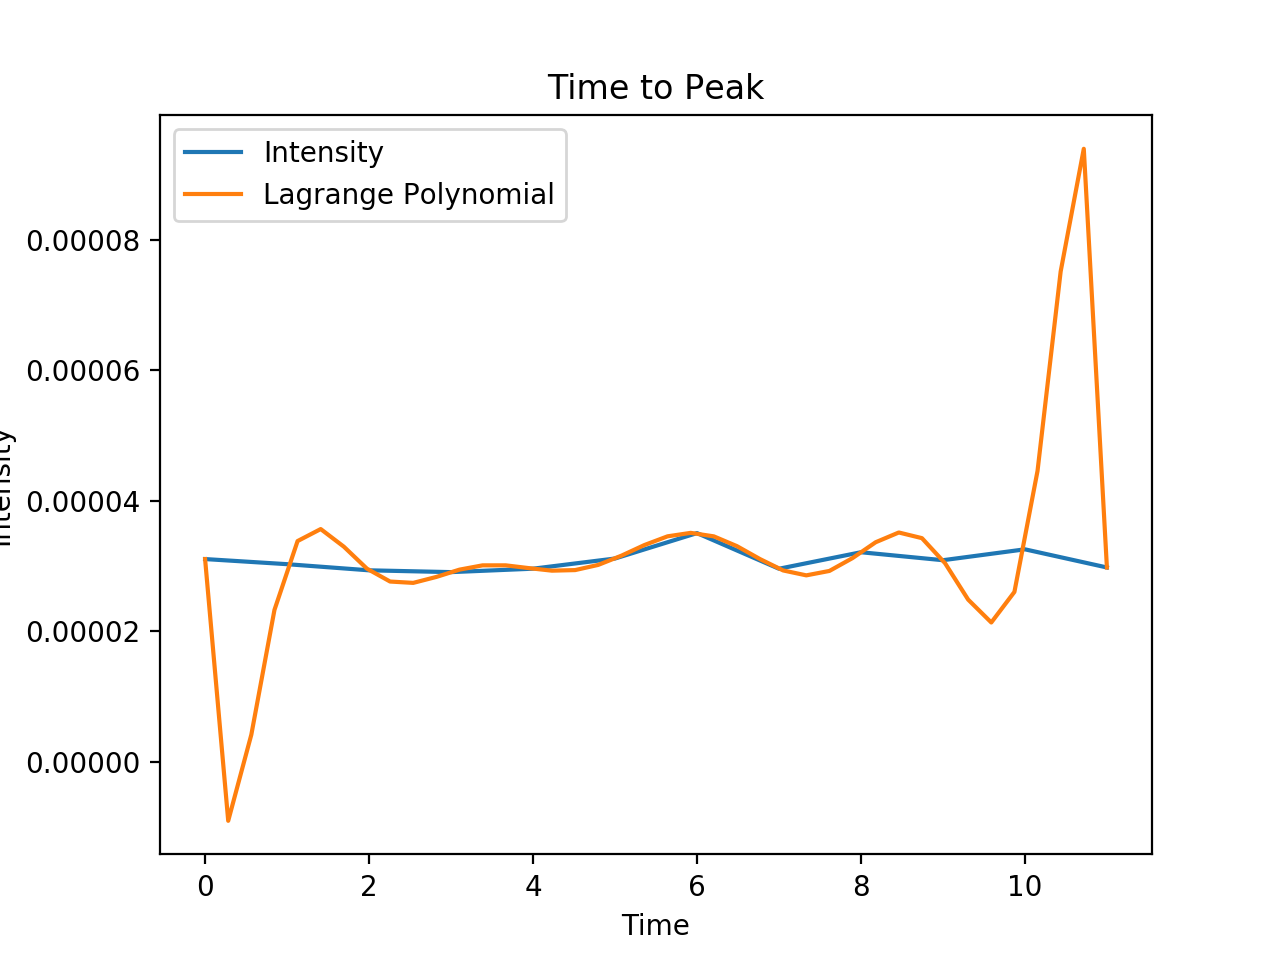

In [21]:
plot_TTP_langrange(voxel_sample_4[17,16,23,:])

<IPython.core.display.Javascript object>


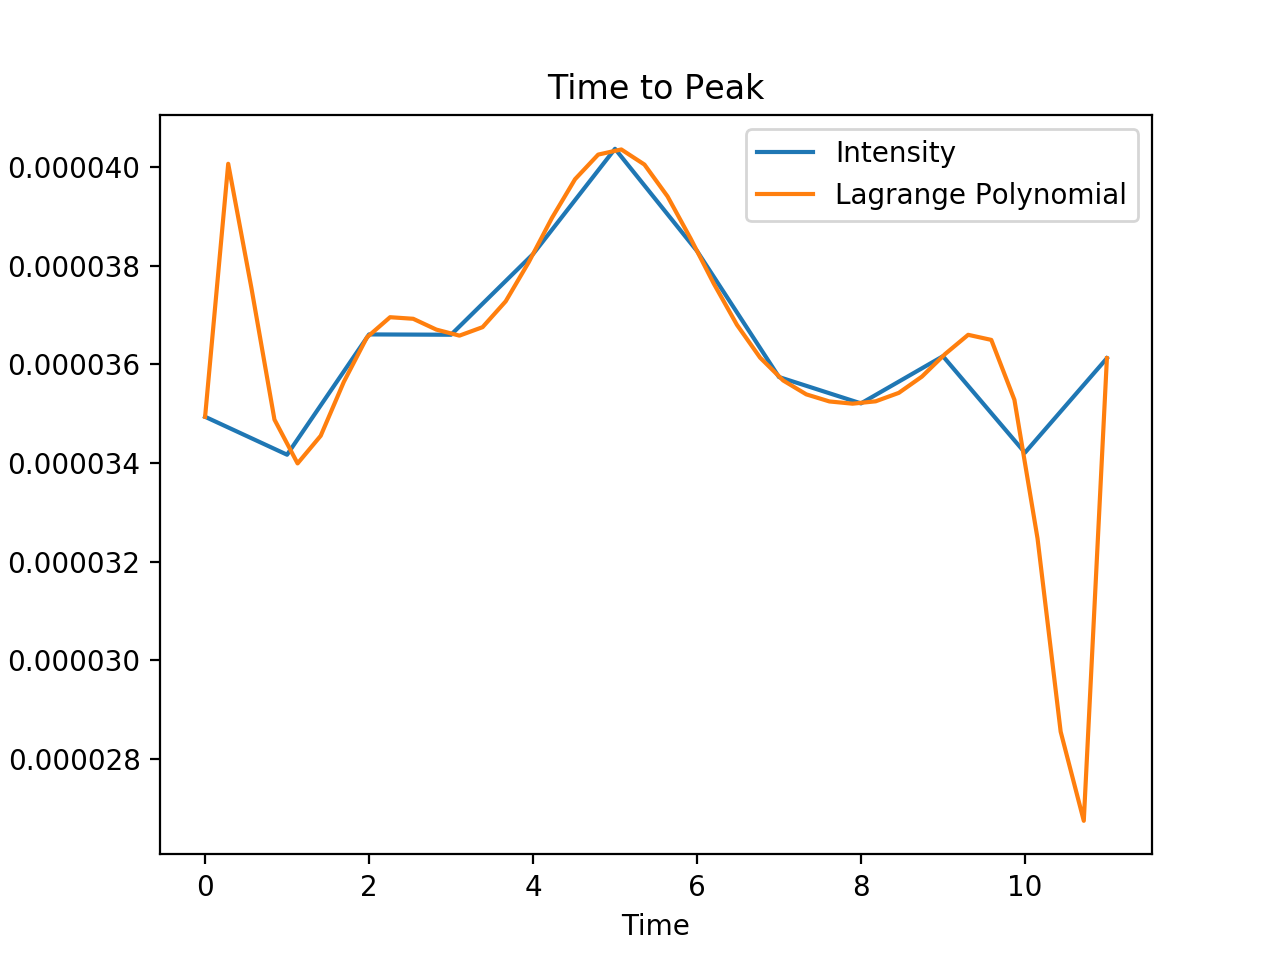

Time to peak value of algorithm:  5.210526315789474
Time to peak value of image:  5.210526315789474
isSame:  True


In [23]:
validate_ttp_sample(18,24, voxel_sample_4)

<h1> Time to Peak with Gaussian Curve Fitting <h1>

In [24]:
#Define gaussian function
def gaussian(x,a,mu,sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [25]:
#Plot intensity values with gaussian curve fitting
#Input: An array of intensity values with length of 6
def plot_gaussian_curve_fit(intensity_values):
    time = np.arange(12)
    fitted_x, fitted_y = gaussian_curve_fitting(intensity_values)
    
    fig = plt.figure()
    plt.plot(time, intensity_values, "o", label = "Measured")
    plt.plot(fitted_x, fitted_y,'r',label='Gaussian Curve Fit')
    plt.xticks(time)
    plt.title("Gaussian Curve Fitting")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.grid()
    plt.legend()
    plt.show()

In [26]:
#Computes gaussian curve fit polynomial for values in [0,11]
def gaussian_curve_fitting(intensity_values):
    n = 12 #len(intensity_values)
    data = intensity_values
    time = np.arange(12)
    fevsize = 208*128*160*13
    
    mean = sum(data*time)/n
    sigma = np.sqrt(sum(data*(time-mean)**2)/n)
    popt,pcov = curve_fit(gaussian,time,data, maxfev=fevsize)
    fitted_x = np.linspace(0,11,20)
    fitted_y = gaussian(fitted_x,*popt)
    ttp_x = fitted_x[np.argmax(fitted_y)]
          
          
    return fitted_x, fitted_y

In [27]:
#Calculates time to peak for gaussian curve fitting
def calculate_time_to_peak_gaussian(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = gaussian_curve_fitting(data)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [33]:
#Validate time to peak output of algorithm with displayed image value 
def validate_time_to_peak_gaussian(x, y, intensity_values):
    sample_array = intensity_values[x,16,y,:]
    plot_gaussian_curve_fit(sample_array)
    fitted_x, fitted_y = gaussian_curve_fitting(sample_array)
    ttp_x_value = fitted_x[np.argmax(fitted_y)]

    print("Time to peak value of algorithm: ", ttp_x_value)
    print("Time to peak value of displayed image: ", time_to_peak_gaussian_4[x,16,y])
    print("isSame: ", time_to_peak_gaussian_4[x,16,y] == ttp_x_value)


In [28]:
#Calculate time to peak with gaussian curve fitting for a 4 voxel sample
time_to_peak_gaussian_4 = calculate_time_to_peak_gaussian(voxel_sample_4)

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


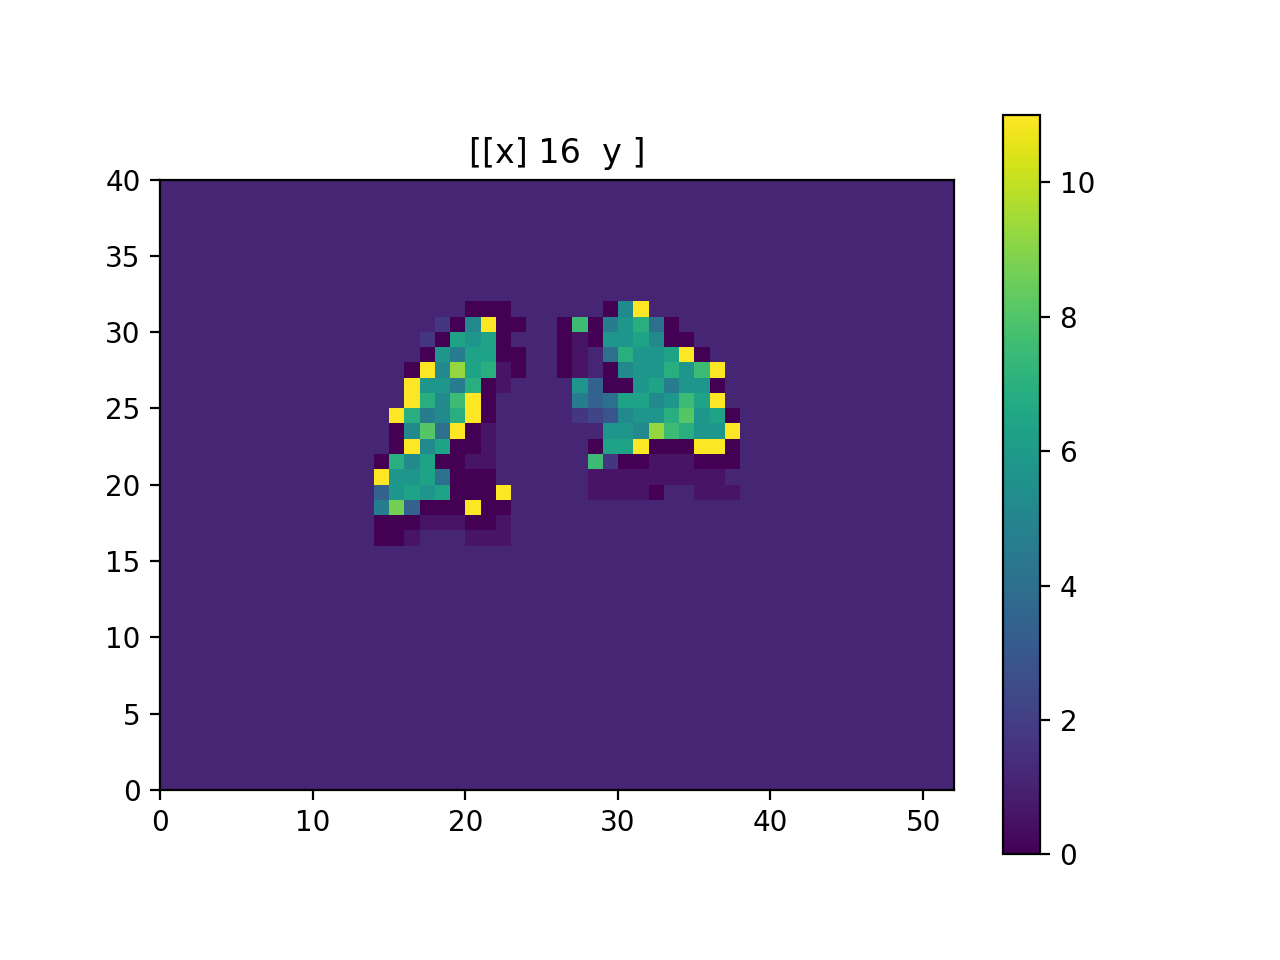

In [48]:
pl.ImagePlot(time_to_peak_gaussian_4, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


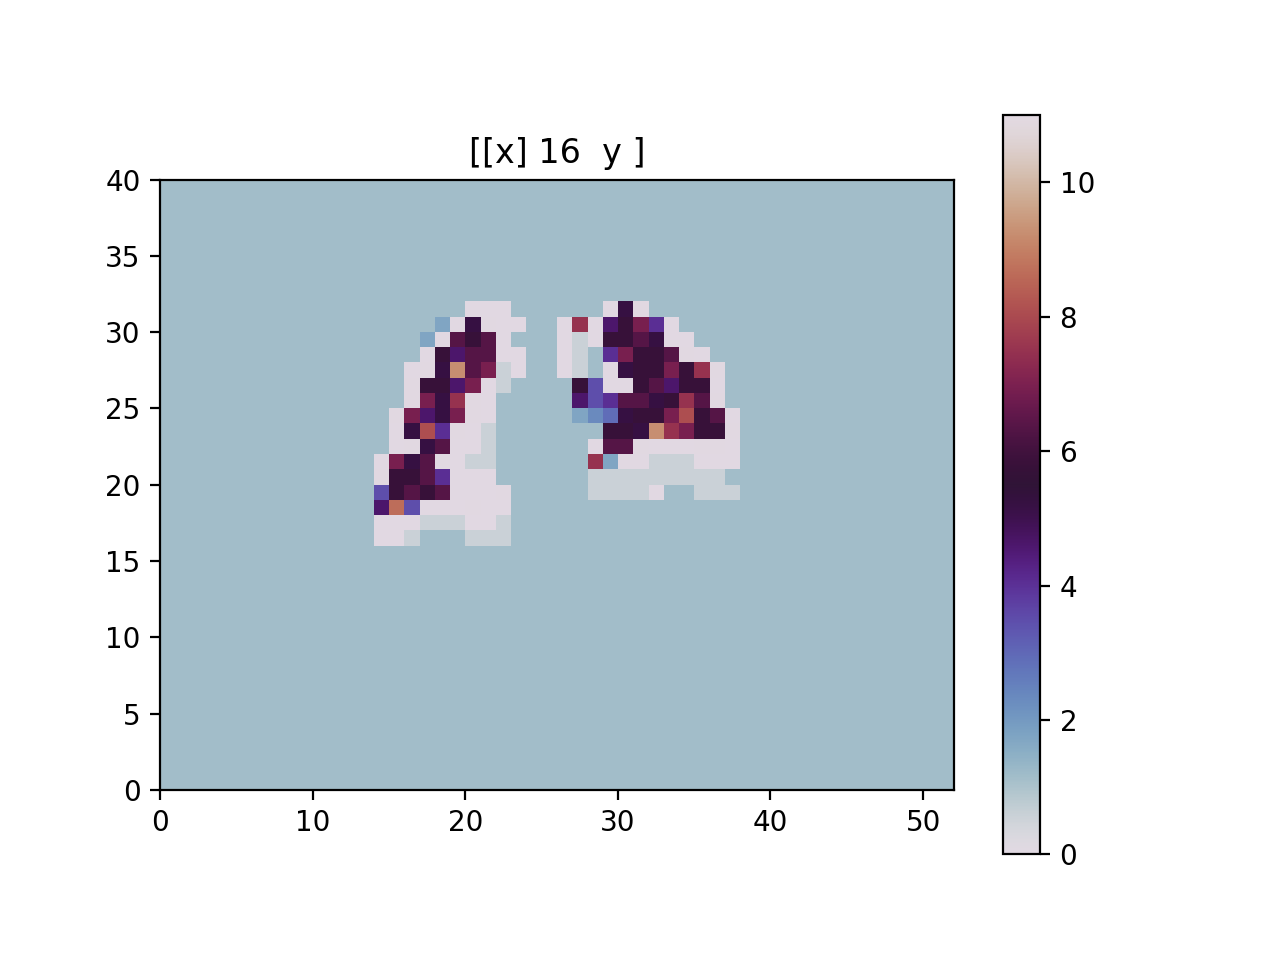

In [49]:
pl.ImagePlot(time_to_peak_gaussian_4, x=0, y=2, colormap ='twilight')

<IPython.core.display.Javascript object>


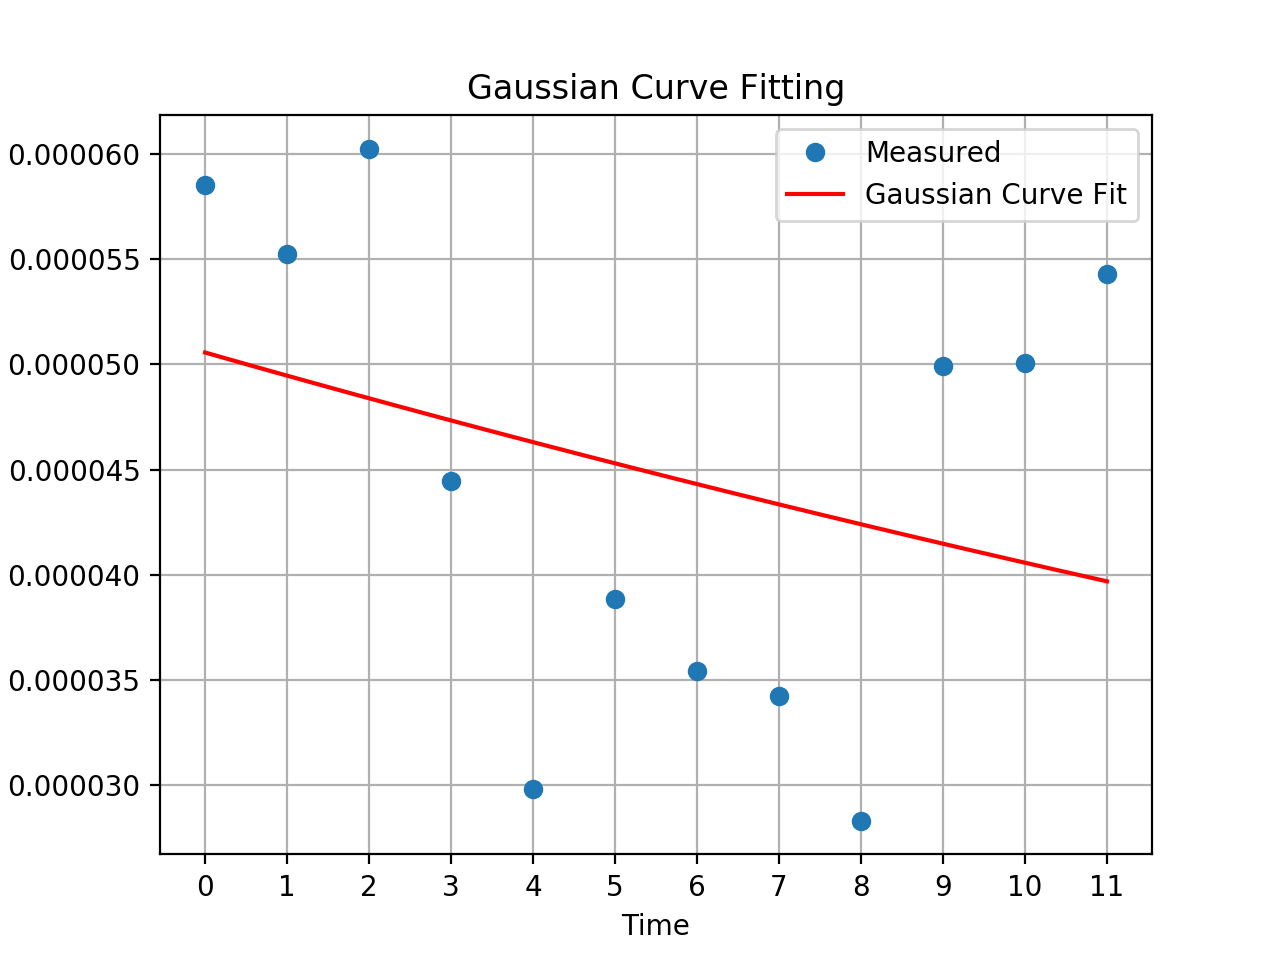

Time to peak value of algorithm:  0.0
Time to peak value of displayed image:  0.0
isSame:  True


In [34]:
#Sample on the edge of lung, green colored 
validate_time_to_peak_gaussian(20,19,voxel_sample_4)

<IPython.core.display.Javascript object>


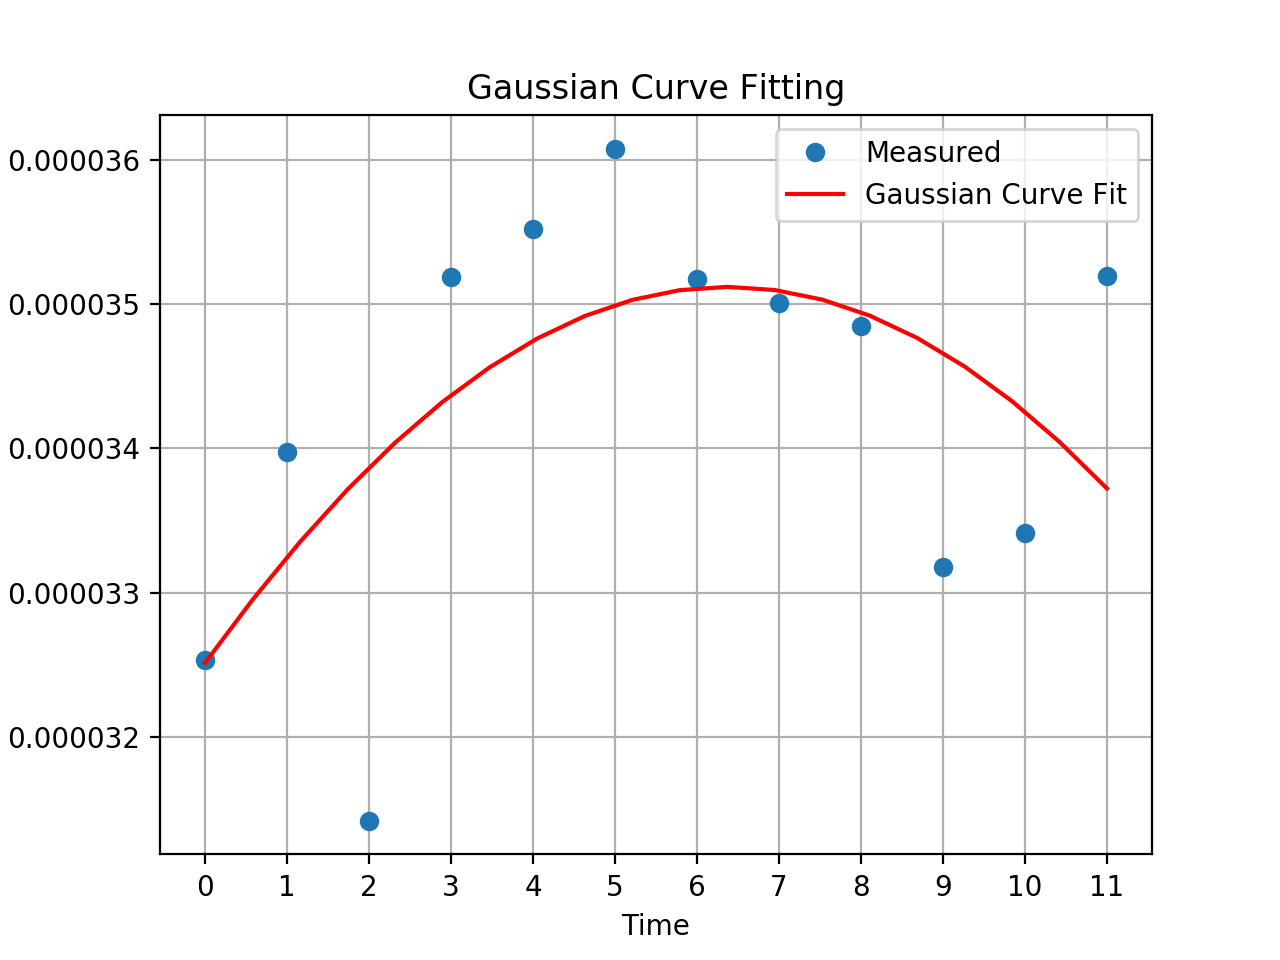

Time to peak value of algorithm:  6.368421052631579
Time to peak value of displayed image:  6.368421052631579
isSame:  True


In [35]:
#Sample on the middle of lung, yellow colored
validate_time_to_peak_gaussian(18,22,voxel_sample_4)

<IPython.core.display.Javascript object>


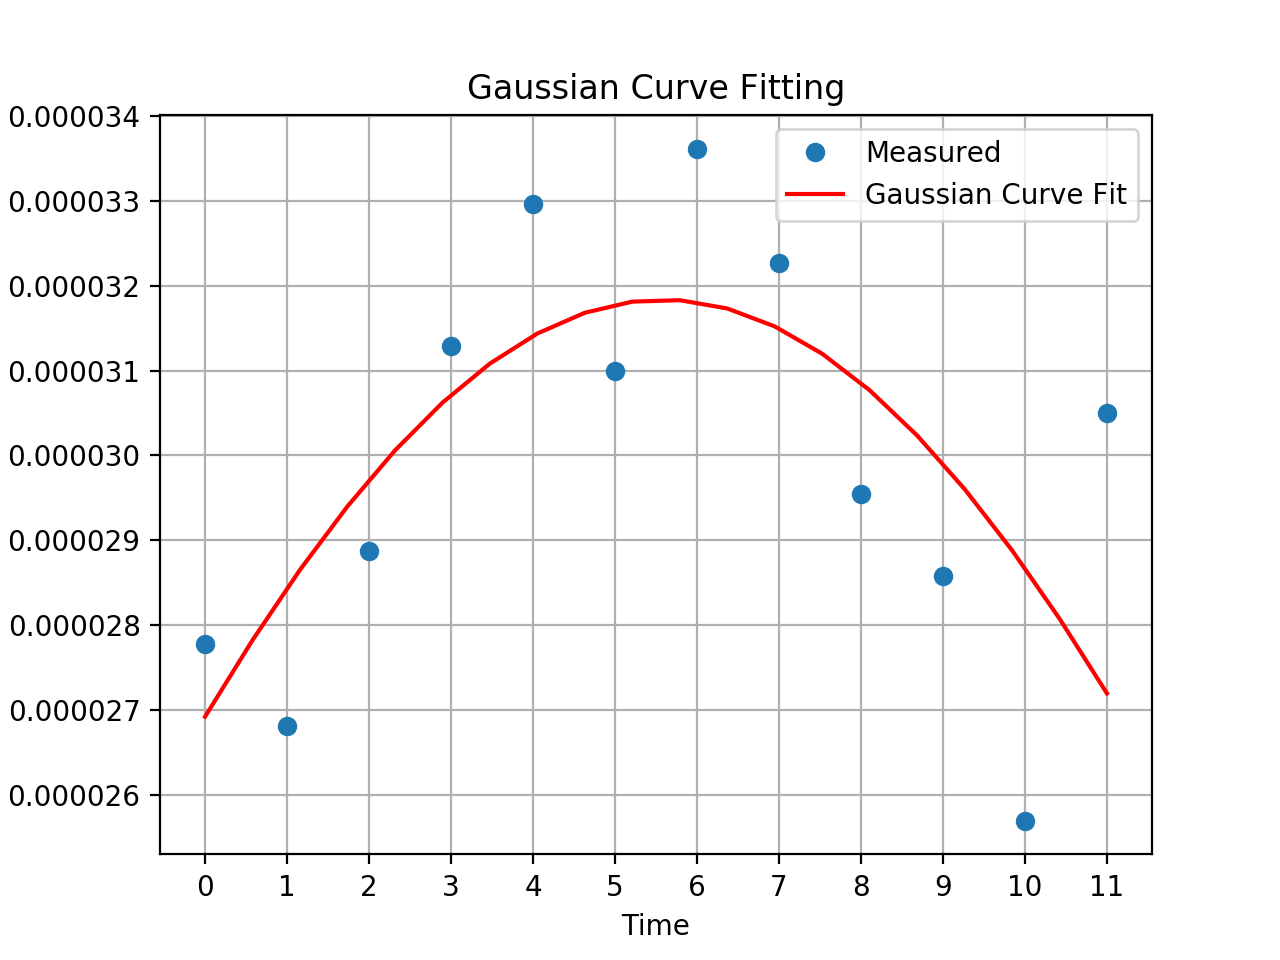

Time to peak value of algorithm:  5.7894736842105265
Time to peak value of displayed image:  5.7894736842105265
isSame:  True


In [36]:
#Sample on the middle of lung, blue colored
validate_time_to_peak_gaussian(16,20,voxel_sample_4)

<h1> Time to Peak with 3rd Degree Polynomial Curve Fitting <h1>

In [39]:
#Plot intensity with 3rd degree polyonimal curve fit
def plot_third_degree_poly_curve_fit(intensity_values):
    poly_x, poly_y = third_degree_poly_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(12), intensity_values, 'o', label='Intensity')
    plt.plot(poly_x, poly_y, label='3rd Degree Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [40]:
#Computes 3rd degree polynomial values in [0,11]
def third_degree_poly_curve_fitting(y_values, samples):
    x_axis = np.linspace(0,11,12)
    poly_x_axis = np.linspace(0,11,num=samples)    
    poly_fit_function = np.poly1d(np.polyfit(x_axis, y_values, 3))
    
    return poly_x_axis, poly_fit_function(poly_x_axis)

In [41]:
#Calculates time to peak for 3rd degree polynomial curve fitting
def calculate_time_to_peak_third_degree_poly(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = third_degree_poly_curve_fitting(data, 20)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [42]:
#Calculate time to peak with 3rd degree polynomial for a 4 voxel sample
time_to_peak_third_degree_poly_4 = calculate_time_to_peak_third_degree_poly(voxel_sample_4)

<IPython.core.display.Javascript object>


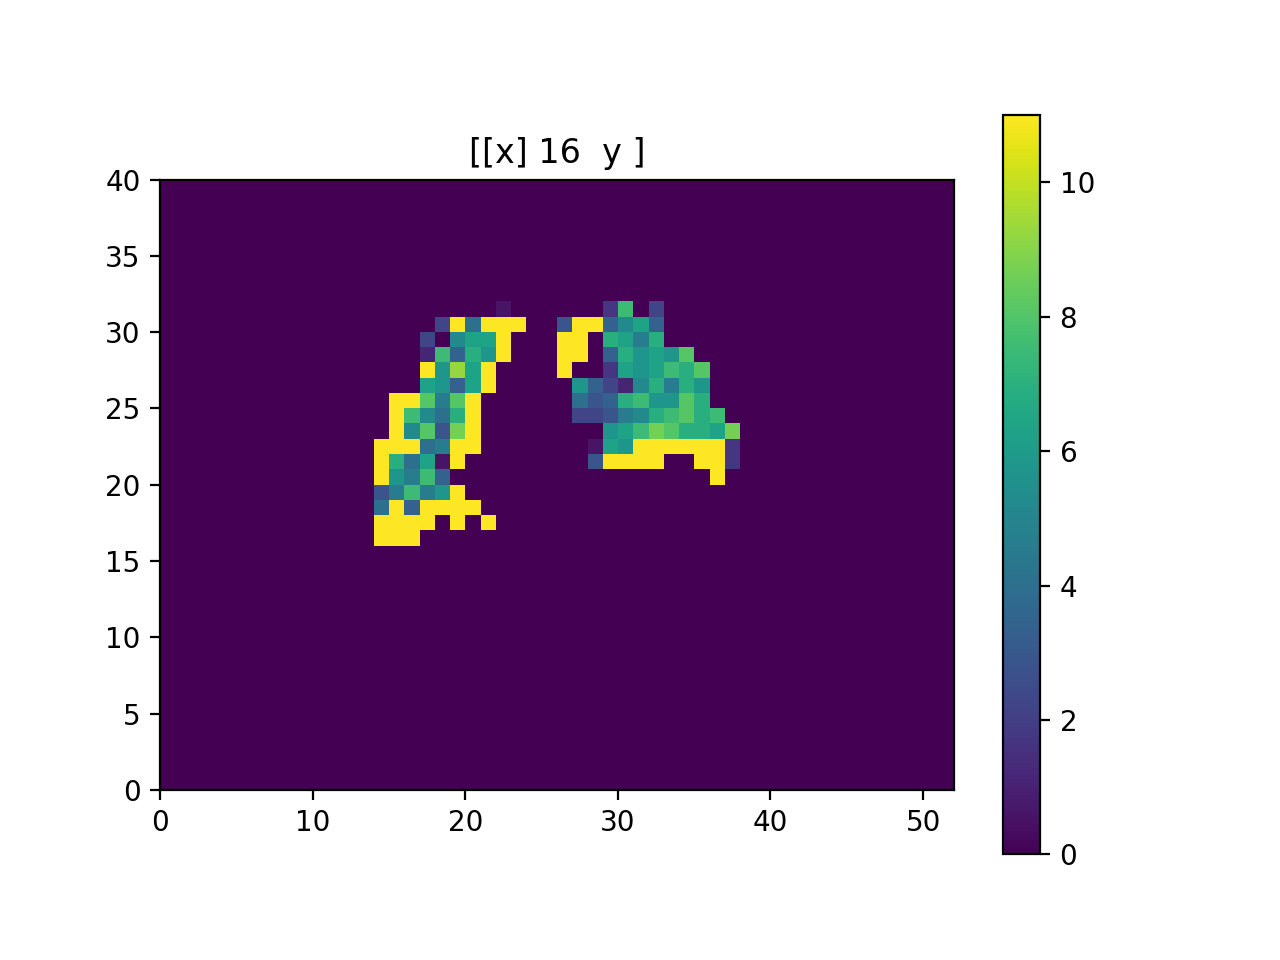

In [43]:
pl.ImagePlot(time_to_peak_third_degree_poly_4, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


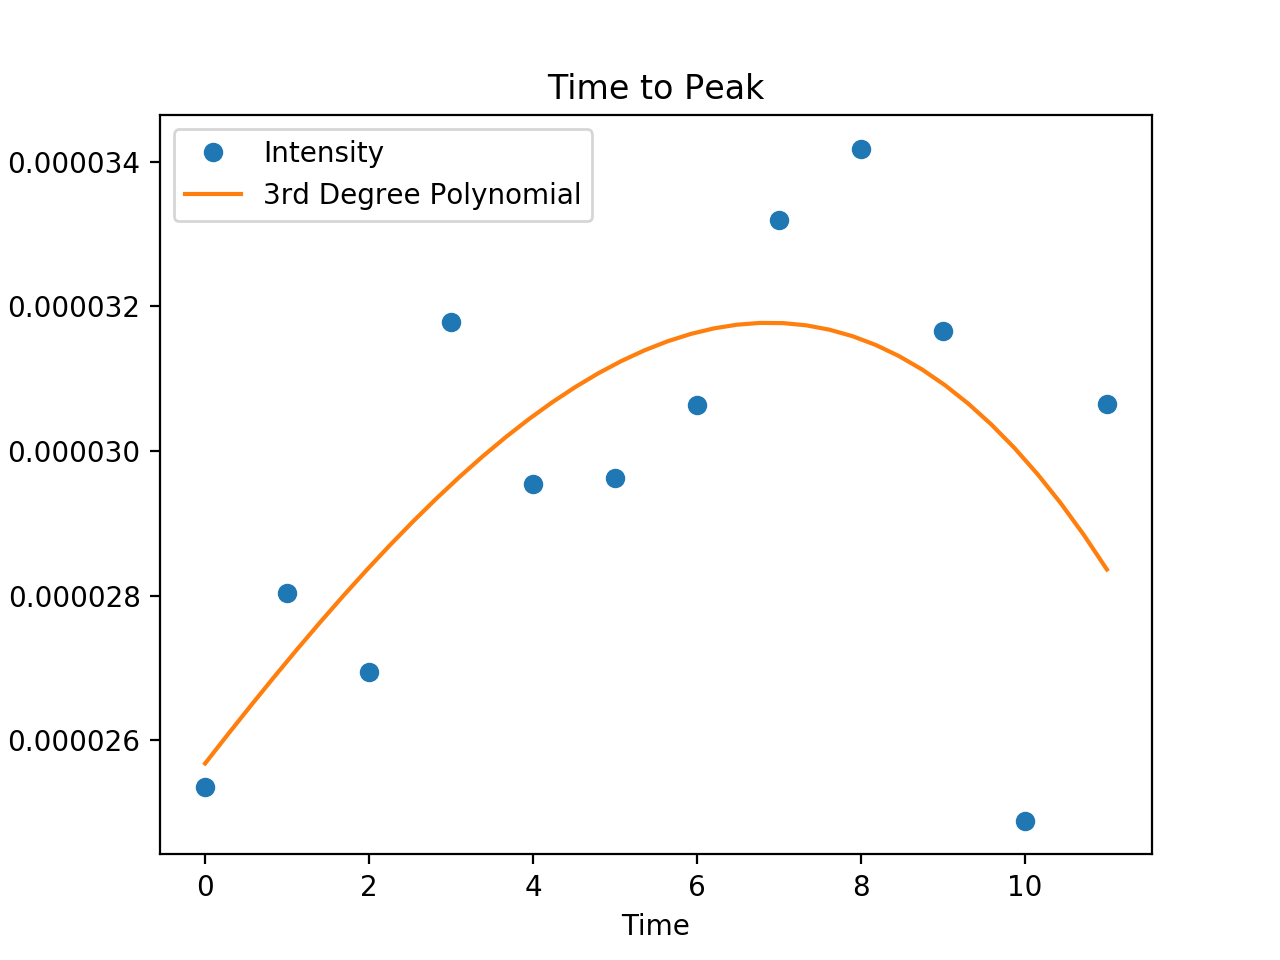

In [56]:
#Sample in the top of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[20,16,28,:])

<IPython.core.display.Javascript object>


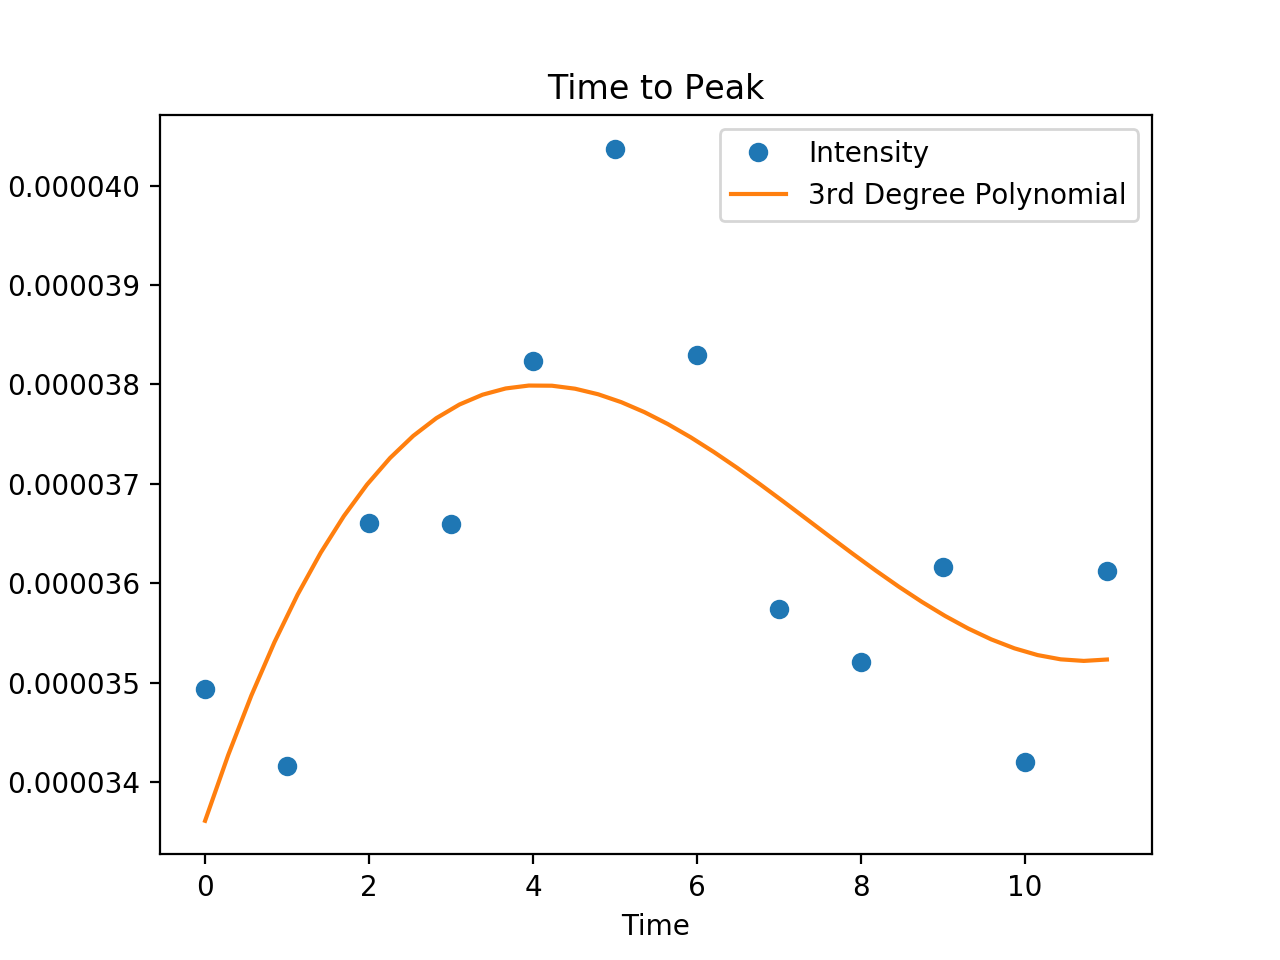

In [55]:
#Sample in the middle of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[18,16,24,:])

<IPython.core.display.Javascript object>


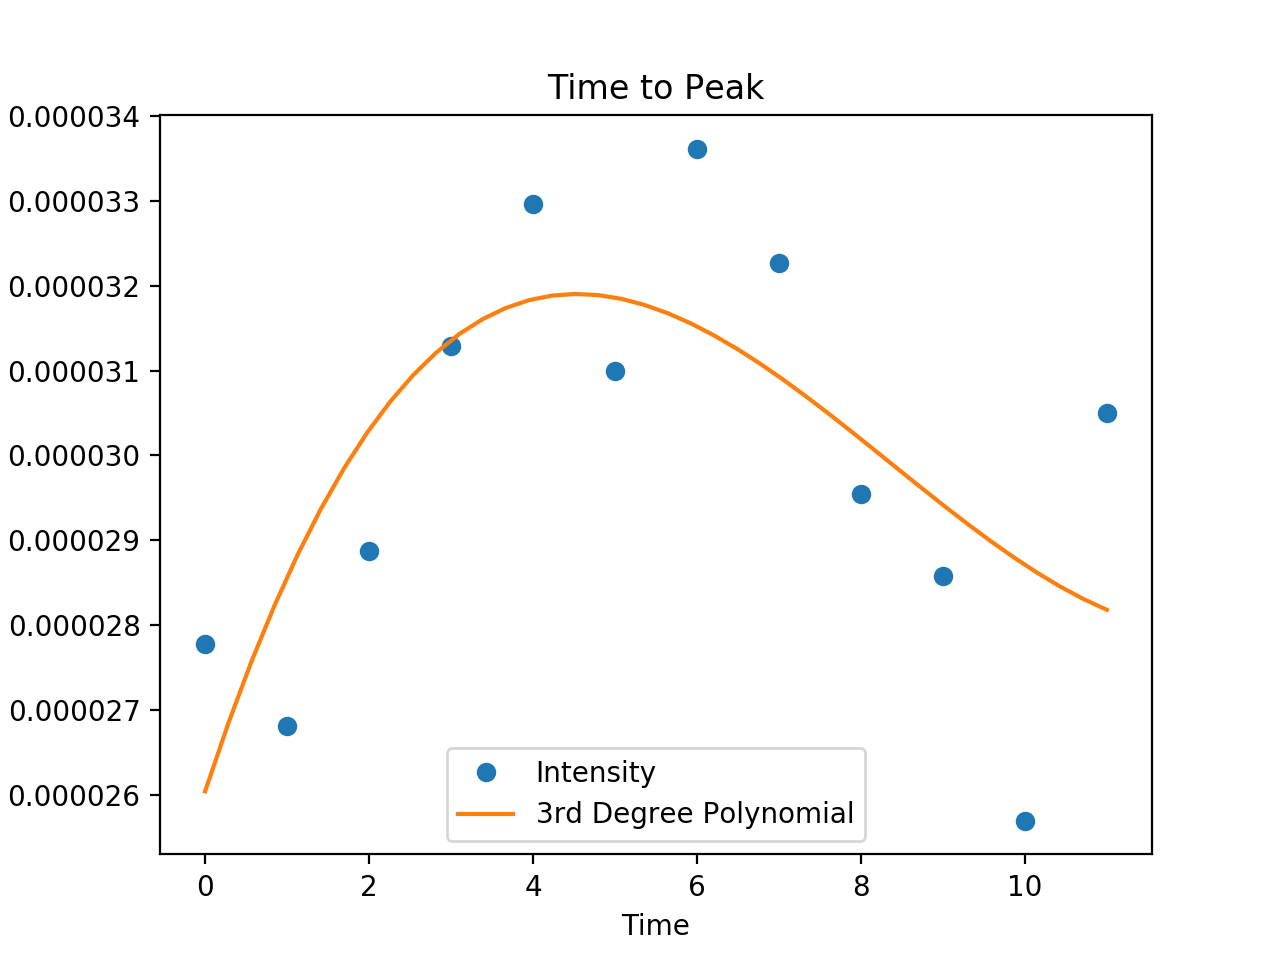

In [46]:
#Sample in the bottom of the left lung
plot_third_degree_poly_curve_fit(voxel_sample_4[16,16,20,:])

In [50]:
#Plot intensity with 3rd degree polyonimal curve fit
def plot_fourth_degree_poly_curve_fit(intensity_values):
    poly_x, poly_y = fourth_degree_poly_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(12), intensity_values, 'o', label='Intensity')
    plt.plot(poly_x, poly_y, label='4th Degree Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [51]:
#Computes 4th degree polynomial values in [0,11]
def fourth_degree_poly_curve_fitting(y_values, samples):
    x_axis = np.linspace(0,11,12)
    poly_x_axis = np.linspace(0,11,num=samples)    
    poly_fit_function = np.poly1d(np.polyfit(x_axis, y_values, 4))
    
    return poly_x_axis, poly_fit_function(poly_x_axis)

In [52]:
#Calculates time to peak for 3rd degree polynomial curve fitting
def calculate_time_to_peak_fourth_degree_poly(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = fourth_degree_poly_curve_fitting(data, 20)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [53]:
#Calculate time to peak with 4th degree polynomial for a 4 voxel sample
time_to_peak_fourth_degree_poly_4 = calculate_time_to_peak_fourth_degree_poly(voxel_sample_4)

<IPython.core.display.Javascript object>


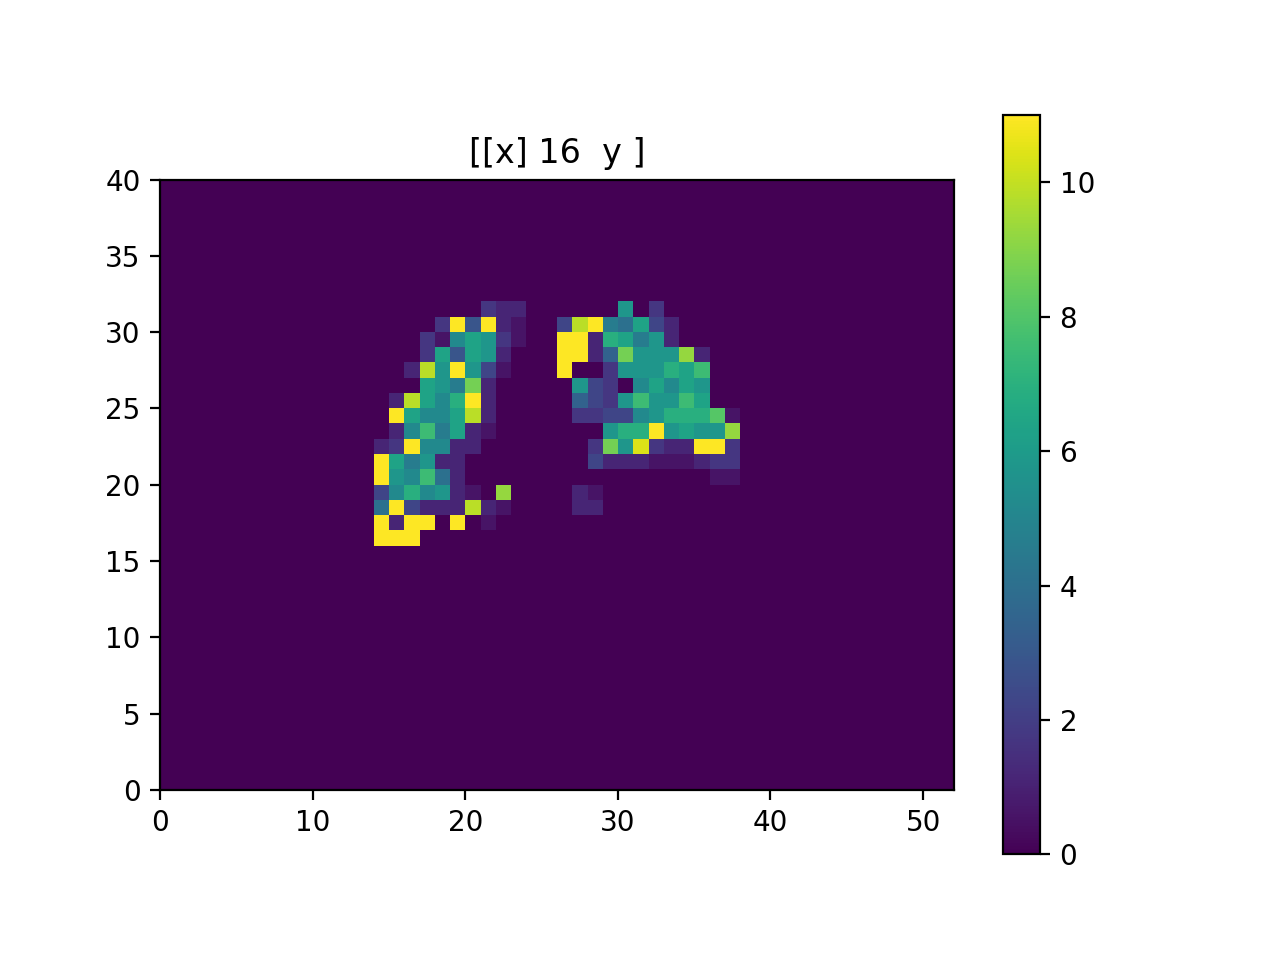

In [54]:
#Plot time to peak of a 4 voxel sample
pl.ImagePlot(time_to_peak_fourth_degree_poly_4, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


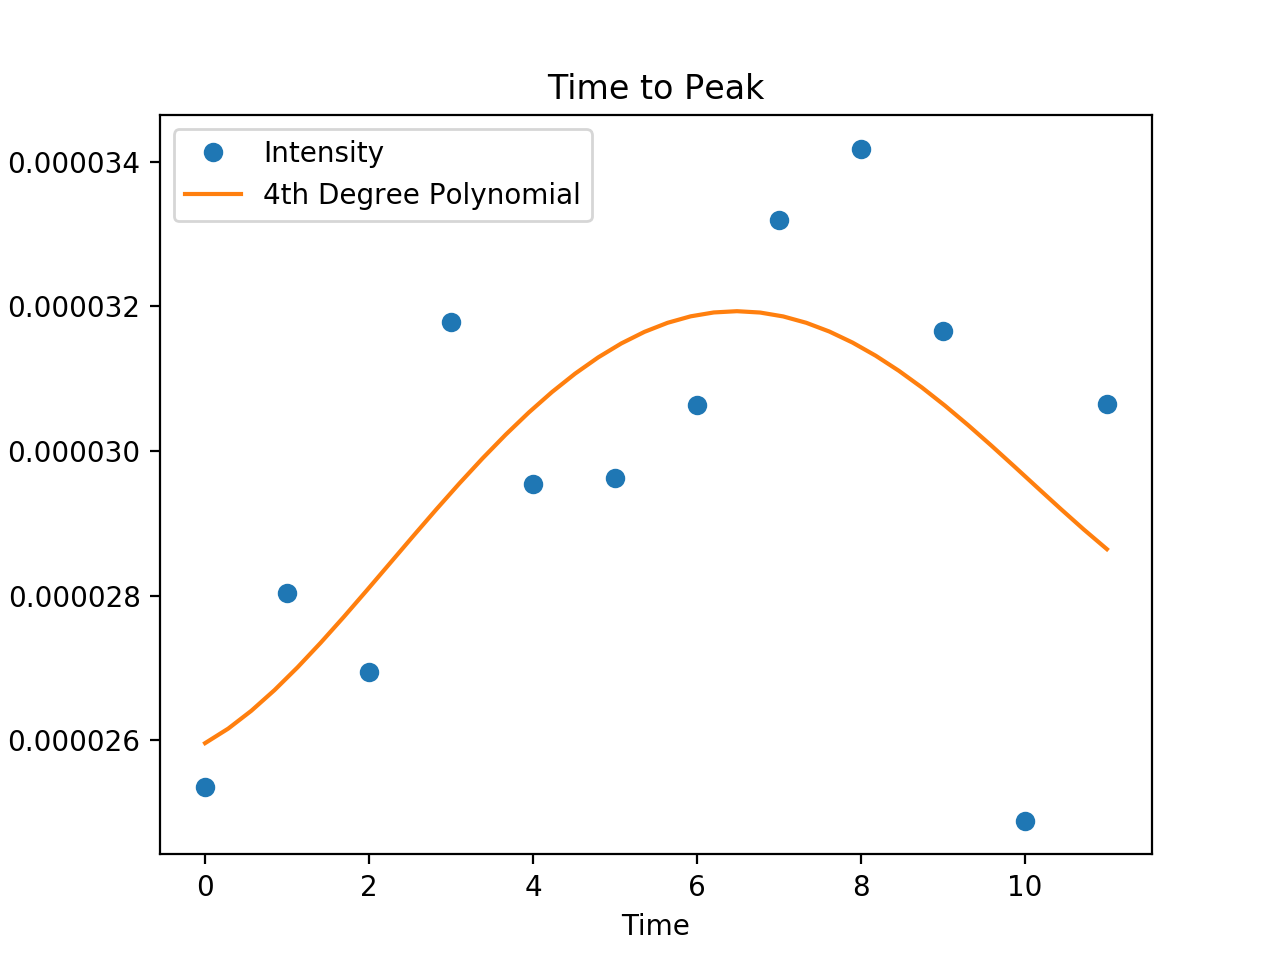

In [60]:
#Sample in the top of the left lung
plot_fourth_degree_poly_curve_fit(voxel_sample_4[20,16,28,:])

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


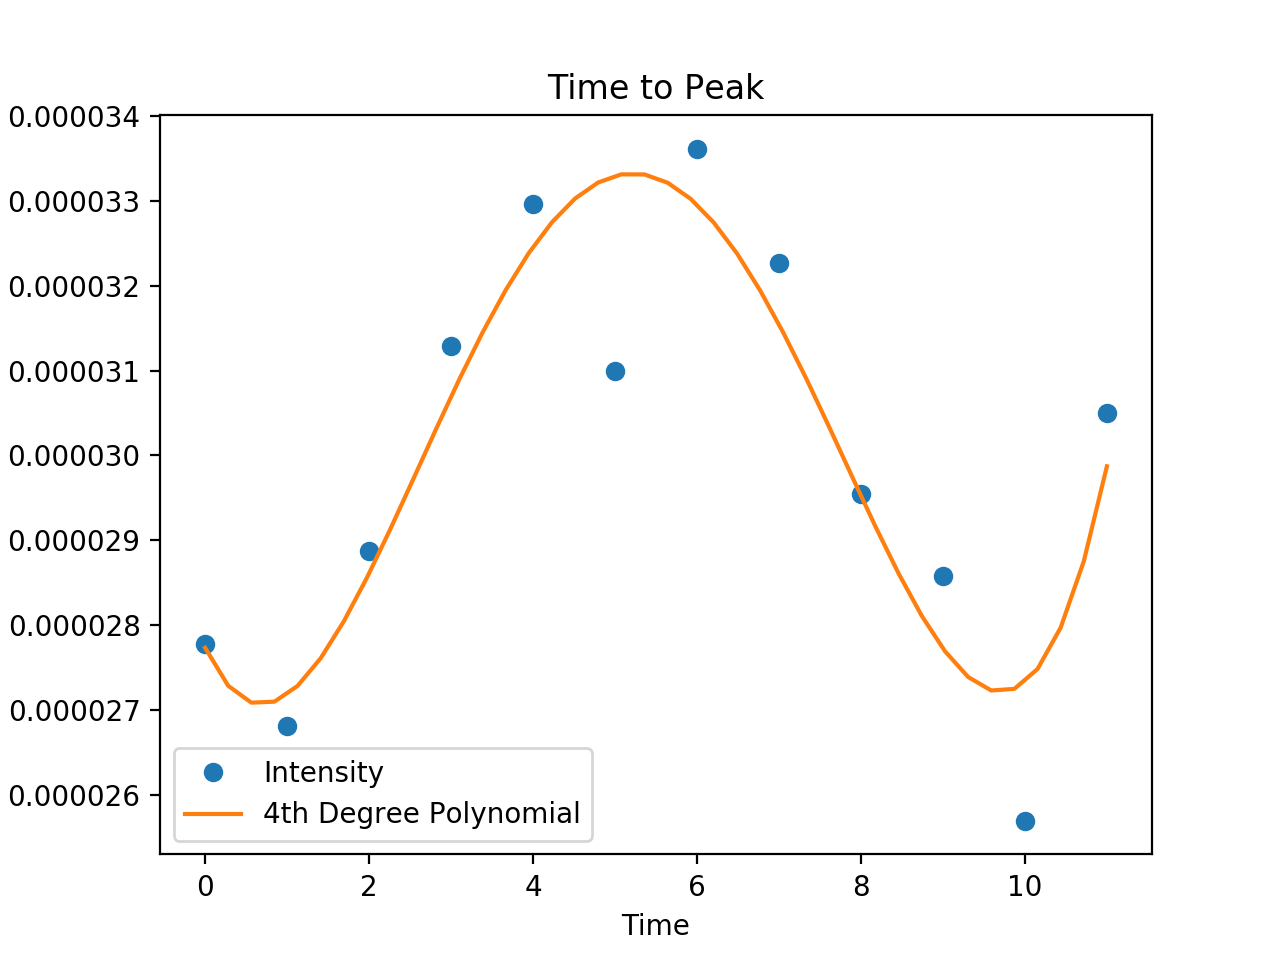

In [61]:
#Sample in the bottom of the left lung
plot_fourth_degree_poly_curve_fit(voxel_sample_4[16,16,20,:])